# Data Preparations

Motivation
*   Apply SHAP (SHapley Additive exPlanations) values to interpret a classification model obtained by training Random Forest.

SHAP (SHapley Additive exPlanations) is a method to explain individual predictions. The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. A player can be an individual feature value, e.g. for tabular data.


In [1]:

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [2]:
from pathlib import Path
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
datasets_folder = Path('/gdrive/My Drive/DATA103/Google Colab/06 Model Explainability')

In [4]:
churn_df = pd.read_csv(datasets_folder/"WA_Fn-UseC_-Telco-Customer-Churn-1.csv")
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
churn_df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [6]:
model_data = churn_df.copy(deep=True)

#remove customerId column from the model data
model_data.drop("customerID", inplace=True, axis=1)
#convert gender to numeric
model_data.gender = model_data.gender.apply(lambda x: 1 if x == 'Female' else 0)
#convert SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn & etc
for c in ['SeniorCitizen', 'Partner',
          'Dependents', 'PhoneService',
          'PaperlessBilling', 'Churn',
          'MultipleLines', 'OnlineSecurity',
          'OnlineBackup', 'DeviceProtection',
          'TechSupport', 'StreamingTV',
          'StreamingMovies']:
    model_data[c] = model_data[c].apply(lambda x: 1 if x == 'Yes' else 0)

#convert TotalCharges to float
model_data.TotalCharges = pd.to_numeric(model_data.TotalCharges, errors='coerce')
model_data.TotalCharges = model_data.TotalCharges.fillna(value=-1)

#one hot encode features with multiple categories
multi_categorical_features = ['InternetService', 'Contract', 'PaymentMethod']
enc = OneHotEncoder(handle_unknown='ignore')
res = enc.fit_transform(model_data[multi_categorical_features])
display(res)
display(res)
display(res.todense())
res_df = pd.DataFrame(res.todense(), columns=enc.get_feature_names_out())
display(res_df)


model_data.drop(multi_categorical_features, axis=1, inplace=True)
model_data = pd.concat([model_data, res_df], axis=1)

model_data.head()

<7043x10 sparse matrix of type '<class 'numpy.float64'>'
	with 21129 stored elements in Compressed Sparse Row format>

<7043x10 sparse matrix of type '<class 'numpy.float64'>'
	with 21129 stored elements in Compressed Sparse Row format>

matrix([[1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.]])

,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
X = model_data.drop("Churn", axis=1) #store to X the features used for modeling (independent variables)
y = model_data["Churn"]#store to y our target (dependent variable)

In [8]:
model_data.Churn.value_counts()

,count
Churn,
0,5174
1,1869


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Random Forest Classifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [11]:
X_train, X_test, y_train, y_test = train_test_split(model_data.loc[:, model_data.columns != 'Churn'],\
                                                    model_data['Churn'], stratify=model_data['Churn'],\
                                                    test_size = 0.4, random_state=66)

#Y variable = Churn

In [12]:
X_train.shape

(4225, 26)

In [13]:
X_test.shape

(2818, 26)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30, max_depth=20, random_state=0, max_features='sqrt',\
                            class_weight='balanced')
rf.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = rf.predict(X_test)

# Print accuracy for the training and test sets
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 0.994
Accuracy on test set: 0.781


In [15]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

array([[1832,  238],
       [ 378,  370]])

In [16]:
# Precision for Class 0
precision_score(y_test, y_pred_test, average=None)[0]

0.8289592760180996

In [17]:
# Precision for Class 1
precision_score(y_test, y_pred_test, average=None)[1]

0.6085526315789473

**Interpretation:** 82.89% of the customers predicted to not churn are actually non-churners while 60.86% of the customers predicted to churn are actually churners. Low precision score for Class 1 (Churners) indicates a need for model improvement.

In [18]:
# Recall Score for Class 0
recall_score(y_test, y_pred_test, average=None)[0]

0.885024154589372

In [19]:
# Recall Score for Class 1
recall_score(y_test, y_pred_test, average=None)[1]

0.4946524064171123

**Interpretation:** 88.50% of the actual non-churners were correctly identified  while 49.47% (approximately half) of the actual churners were correctly identified.  Low recall score for Class 1 (Churners) indicates a need for model improvement.

In [20]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2070
           1       0.61      0.49      0.55       748

    accuracy                           0.78      2818
   macro avg       0.72      0.69      0.70      2818
weighted avg       0.77      0.78      0.77      2818



**Interpretation for f1-score:** With the model performing well in predicting non-churners (Class 0) with an F1 score of 0.86, the model needs to improve predicting for Class 1 (churners) considering its lower F1 score of 0.55.

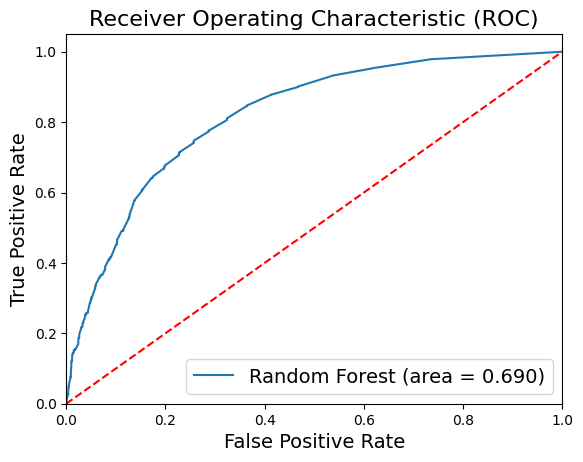

In [21]:
# Building ROC curve
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show();

The ROC curve is quite near the red line with a 69% chance of correctly distinguishing between Class 1 (Churners) and Class 0 (Non-Churners). This indicates that improvements to the model's  better class separation should be done.

# SHAP Values

In [22]:
# Import the package
import shap
shap.initjs()

In [23]:
%time
samples = X_train

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

print(f"Shape of aggregated shap_values: {shap_values_aggregated.shape}")
print(f"Shape of samples: {samples.shape}")

shap.summary_plot(shap_values[:, :, 1], samples,max_display=20)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs


NameError: name 'shap_values_aggregated' is not defined

The SHAP summary plot above shows the list of top 20 features and their indications of the relationship between the value of a feature and the impact on the classification model.

 It suggests that tenure has the highest impact on the model's predictions, followed by other features like Month-to-Month Contract and Fiber Optic Internet Service. .

In [ ]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):

    '''
    A function for building a SHAP waterfall plot.

    SHAP waterfall plot is used to visualize the most important features in a descending order.

    Parameters:
    shap_values (list): SHAP values obtained from a model
    features (pandas DataFrame): a list of features used in a model
    num_display(int): number of features to display

    Returns:
    matplotlib.pyplot plot: SHAP waterfall plot

    '''

    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]

    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4

    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)

    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

In [ ]:
# Shapp waterfall plot
make_shap_waterfall_plot(shap_values[:, :, 1], samples)

#changed shap_values[1] to shap_values[:, :, 1]

Based on the SHAP waterfall plot,tenue is the most important feature in the model, which has more than 10% of the model's explainability. Also, these top 20 features provide more than 90% of the model's interpretation.

In [ ]:
# Let's have a look on the top features and their dependence plots
top_features = ['tenure', 'Contract_Month-to-month', 'InternetService_Fiber optic', 'TotalCharges']
feature_list = ['MonthlyCharges', 'Contract_Two year', 'PaymentMethod_Electronic check']

In [ ]:
for feature in top_features:
    shap.dependence_plot(feature, shap_values[:, :, 1], samples, interaction_index=None)

Based on the SHAP dependence plots, it is clear that clients, who churned to telco services tend to have the following features (y>0):

- less than 10 months of tenure with the company
- have a month-to-month contract instead of 1-2 years
- internet service provider is fiber optic
- total amount charged to customer is less than 2000

On the other hand, clients, who did NOT churn to the service but remained may have the following features:

- more than 10 months of tenure with the company
- have 1-2 years contract with company
- internet service provider is dsl
- total amount charged to customer is more than 2000

In [ ]:
for feature in feature_list:
    shap.dependence_plot(feature, shap_values[:, :, 1], samples, interaction_index=None)

Also looking at the other features we can say that

- the higher the monthly charge to the customer, the higher the probability to churn on the telco service,
- two-year contracts likely do not lead to churns
- those who paid with electronic checks likely lead to churns

# LIME

LIME stands for Local Interpretable Model-agnostic Explanations. LIME focuses on training local surrogate models to explain individual predictions. Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models. Surrogate models are trained to approximate the predictions of the underlying black box model. Instead of training a global surrogate model, LIME focuses on training local surrogate models.

LIME is model-agnostic, meaning that it can be applied to any machine learning model. The technique attempts to understand the model by perturbing the input of data samples and understanding how the predictions change.

" Why was this prediction made or which variables caused the prediction.?"

Why are there many instances in Lime?
- 5th, 10th, 15th, 20th, etc
-  each "instance" refers to a single observation or data point in your test set for which you want to generate an explanation.
- The reason for using multiple instances is to understand how your model behaves across different cases, rather than just one particular prediction.
-

In [ ]:
#Import Lime Package
!pip install lime
import lime
import lime.lime_tabular

In [ ]:
#Create Explainer

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')

In [ ]:
# Assuming you have your training and test data ready
# Define and train your model
model = RandomForestClassifier()
model.fit(X_train, y_train)  # X_train and y_train should be your training data and labels

## Select 5th Instance

In [ ]:
#Here, I will choose 5 instances and use them to explain the predictions.
# Choose the 5th instance and use it to predict the results
j = 5
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=6)

#num_features to tweak number of features shown

In [ ]:
# Show the predictions
exp.show_in_notebook(show_table=True)

**Interpretation**
The predicted value of the customer type is a non-churner for the 5th instance
The variables of fiber optic internet service, month-to-month contract, two year contract, tenure between 29 to 55 months, and monthly charge above 35.10 except those customers without internet service have negative influence on the churn scenario. On the means, these negative variables means these features make it more likely for the model to predict "non-churn" rather than simply not "churn." While the feature "no internet service incidates a positive value wherein it is likely a contributor to churn.

Negative Influence: In this case, it means that these features make it less likely for the instance to belong to the predicted positive class (no churn).


In [ ]:
exp.as_list()

## Select 10th Instance

In [ ]:
# Choose the 10th instance and use it to predict the results
j = 10
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=6)

In [ ]:
# Show the predictions
exp.show_in_notebook(show_table=True)

Interpretation The predicted value of the customer type is a non-churner for the 10th instance. The results suggest that contracts of two year and customers with no internet service contributes to churn predictions.

 The variables of fiber optic internet service, month-to-month contract, tenure between 29 to 55 months, and internet service provided by DSL  have negative influence on the churn scenario. On the means, these negative variables means these features make it more likely for the model to predict "non-churn" rather than simply not "churn."

Negative Influence: In this case, it means that these features make it less likely for the instance to belong to the predicted positive class (no churn).

In [ ]:
exp.as_list()

## Select 15th Instance

In [ ]:
# Choose the 15th instance and use it to predict the results
j = 15
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=6)

In [ ]:
# Show the predictions
exp.show_in_notebook(show_table=True)

The predicted value of the customer type is a non-churner for the 15th instance. The results suggest that none of the features contributes to churn predictions.

The variables of fiber optic internet service, month-to-month contract, tenure between 29 to 55 months, and internet service provided by DSL have negative influence on the churn scenario. On the means, these negative variables means these features make it more likely for the model to predict "non-churn" rather than simply not "churn."

Negative Influence: In this case, it means that these features make it less likely for the instance to belong to the predicted positive class (no churn).

In [ ]:
exp.as_list()

# Partial Dependence Plots

 We can interpret the partial dependence as the expected target response as a function of the input features of interest.

 Due to the limits of human perception, the size of the set of input features of interest must be small (usually, one or two) thus the input features of interest are usually chosen among the most important features.



In [ ]:
#1 Way Partial Dependence


from sklearn.inspection import PartialDependenceDisplay
from time import time
from sklearn.neural_network import MLPRegressor

# Define and train the model
mlp_model = MLPRegressor()  # You may need to specify parameters
mlp_model.fit(X_train, y_train)  # Ensure X_train and y_train are defined


In [ ]:

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["InternetService_Fiber optic", "Contract_Month-to-month", "tenure", "MonthlyCharges","Contract_Two year","InternetService_No"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": [0,1],
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        "Partial dependence of the likeliness to churn\n"
        " with an MLPRegressor"
    ),
    fontsize=16,
)

- InternetService_Fiber optic: When a customer has fiber optic provider, it will more likely churn; although effect is minor
- Contract_Month-to-month: When a customer has a month-to-month contract, it will more likely churn; although effect is minor
- Tenure(POSSIBLE ERROR?) - The higher the tenure, the more likely a person will churn
- Month Charges - relatively flat with a slight downward trend on the initial parts while increasing in the latter, indicating that customers with lower monthly billings are more likely to churn, while those with higher monthly billings to pay are less likely to churn -- but the effect is almost minimal cosndering it is almost flat.
- Contract_Two Years - Customers with two years contract are less likely to
churn compared to those with internet service.
- Internet Service_No - Customers without internet service are less likely to
churn compared to those with internet service.





In [ ]:
#PENDING
- ung tenure??
- Identify the top 3-5 features with the most significant impact on the model's predictions (positive or negative influence on churn prediction).